In [1]:
%pylab inline
from __future__ import print_function

import cPickle as pickle
import enum
import os
import time
import IPython

import numpy as np
import scipy
import sklearn.metrics.pairwise

import librosa

from moviepy.editor import *

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


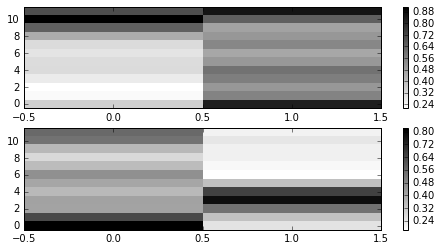

In [2]:
def read_beat_chroma_labels(filename):
    """Read back a precomputed beat-synchronous chroma record."""
    with open(filename, 'rb') as f:
        beat_times, chroma_features, label_indices = pickle.load(f)
    return beat_times, chroma_features, label_indices

def my_imshow(data, **kwargs):
    """Wrapper for imshow that sets common defaults."""
    plt.imshow(data, interpolation='nearest', aspect='auto', origin='bottom', cmap='gray_r', **kwargs)
    
# Where to find the data (on my machine).
DATA_DIR = '/Users/the_goat/Desktop/final_project_thunderbolt/'
FEATURES_DIR = os.path.join(DATA_DIR, 'beatchromftrs')

def chroma_for_id(id_):
    """Return just the chroma array for a given ID."""
    _, chroma, _ = read_beat_chroma_labels(os.path.join(FEATURES_DIR, id_ + '.pkl'))
    return chroma

# Look at the first chunk of chroma features for audio track
ftrs_1 = chroma_for_id('1')
ftrs_2 = chroma_for_id('one')

plt.figure(figsize=(8,4))
subplot(211)
my_imshow(ftrs_1[:100].transpose())
colorbar()
subplot(212)
my_imshow(ftrs_2[:100].transpose())
colorbar()

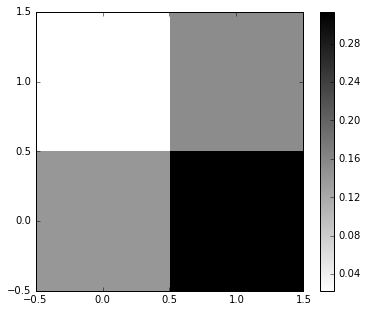

In [3]:
# Make an "all pairs" distance matrix.
index = 0
local_costs = sklearn.metrics.pairwise.pairwise_distances(chroma_for_id('1'), 
                                                          chroma_for_id('one'), metric='cosine')
plt.figure(figsize=(6,5))
limit = 200
my_imshow(local_costs[:limit, :limit])
colorbar()

In [4]:
# Define the core DTW calculation.
import numba

DIAGONAL = 0
HORIZONTAL = 1
VERTICAL = 2

@numba.jit(nopython=True)
def dtw_core(dist_mat, penalty, traceback):
    """Core dynamic programming routine for DTW.
    `dist_mat` and `traceback` will be modified in-place.

    Args:
      dist_mat : np.ndarray
        Distance matrix to update with lowest-cost path to each entry.
      penalty : int or float
        Additive penalty for non-diagonal moves.
      traceback : np.ndarray
        Matrix to populate with the lowest-cost traceback from each entry.
    """
    # At each iteration, we are computing lowest cost to D[row, col].
    for row in xrange(1, dist_mat.shape[0]):
        dist_mat[row, 0] += dist_mat[row - 1, 0] + penalty
        traceback[row, 0] = VERTICAL
    for col in xrange(1, dist_mat.shape[1]):
        dist_mat[0, col] += dist_mat[0, col - 1] + penalty
        traceback[0, col] = HORIZONTAL
    for col in xrange(1, dist_mat.shape[1]):
        for row in xrange(1, dist_mat.shape[0]):
            diag_cost = dist_mat[row - 1, col - 1]
            vert_cost = dist_mat[row - 1, col] + penalty
            horiz_cost = dist_mat[row, col - 1] + penalty
            # Diagonal move (which has no penalty) is lowest
            if diag_cost <= horiz_cost and diag_cost <= vert_cost:
                traceback[row, col] = DIAGONAL
                dist_mat[row, col] += diag_cost
            # Horizontal move (has penalty)
            elif horiz_cost <= vert_cost:
                traceback[row, col] = HORIZONTAL
                dist_mat[row, col] += horiz_cost
            # Vertical move (has penalty)
            else:
                traceback[row, col] = VERTICAL
                dist_mat[row, col] += vert_cost

def find_traceback(traceback_matrix, ending_row, ending_col, local_costs_matrix=None):
    """Decode the traceback matrix from the given ending point to a full path."""
    row = ending_row
    col = ending_col
    path = [(row, col)]
    path_costs = []
    if local_costs_matrix is not None:
        path_costs.append(local_costs_matrix[row, col])
    while row > 0 or col > 0:
        predecessor = traceback_matrix[row, col]
        if predecessor == HORIZONTAL:
            col = col - 1
        elif predecessor == VERTICAL:
            row = row - 1
        else:
            col = col - 1
            row = row - 1
        path.append((row, col))
        if local_costs_matrix is not None:
            path_costs.append(local_costs_matrix[row, col])
    return np.array(path[::-1]), np.array(path_costs[::-1])

def dtw(local_costs, penalty=0.2):
    """Perform DTW over a local_costs matrix and return path, best cost, and path costs."""
    distance_matrix = np.copy(local_costs)
    traceback = np.empty(distance_matrix.shape, np.uint8)
    dtw_core(distance_matrix, penalty, traceback)
    path, path_costs = find_traceback(traceback, distance_matrix.shape[0] - 1, distance_matrix.shape[1] - 1, 
                                      local_costs + penalty*(traceback != DIAGONAL))
    return path, distance_matrix[-1, -1], path_costs

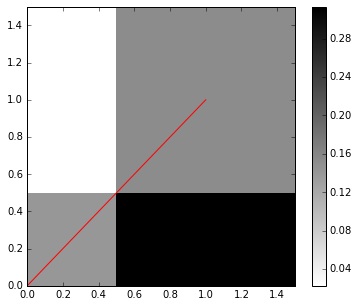

In [5]:
# Calculate DTW through the local_costs matrix and plot the path atop the local costs.
path, best_cost, path_costs = dtw(local_costs)

limit = 1.5 
plt.figure(figsize=(6,5))
my_imshow(local_costs)
colorbar()
plot(path[:, 1], path[:, 0], '-r')
if limit:
    ylim([0, limit])
    xlim([0, limit])

Mean:
0.247573883563
Median:
0.247573883563
Fri May  6 00:05:48 2016 0 of 8 
Fri May  6 00:05:48 2016 1 of 8 
Fri May  6 00:05:48 2016 2 of 8 
Fri May  6 00:05:48 2016 3 of 8 
Fri May  6 00:05:48 2016 4 of 8 
Fri May  6 00:05:48 2016 5 of 8 
Fri May  6 00:05:48 2016 6 of 8 
Fri May  6 00:05:48 2016 7 of 8 
Time per comparison= 0.00168134375 seconds.
Reference: 
['one', 'one', 'seven', 'seven', 'two', 'two', 'four', 'four']
Input: 
['1', '1', '7', '7', '2', '2', '4', '4']


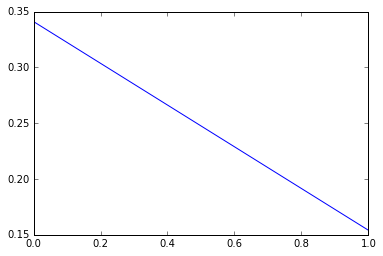

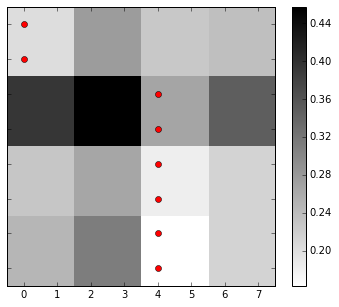

In [6]:
# Looking at the per-step costs down the best path give some measure of match quality.
plot(path_costs)
print("Mean:")
print(np.mean(path_costs))
print("Median:")
print(+ np.median(path_costs))


def calculate_track_distance_matrix(ids_A, ids_B, distance_function):
    """Pass all pairs of tracks to a distance function, return array."""
    start_time = time.clock()
    scores = np.zeros((len(ids_A), len(ids_B)))
    for n_A, id_A in enumerate(ids_A):
        ftrs_A = chroma_for_id(id_A)
        print(time.ctime(), n_A, "of", len(ids_A), os.path.dirname(id_A))
        for n_B, id_B in enumerate(ids_B):
            scores[n_A, n_B] = distance_function(ftrs_A, chroma_for_id(id_B))
    print("Time per comparison=", (time.clock() - start_time)/(len(ids_A) * len(ids_B)), "seconds.")
    return scores

# Calculate distances over test set using median path cost.
def dtw_distance(ftrs_A, ftrs_B):
    """Return a cover song match score as the best cost of locally-normalized local costs."""
    local_costs = sklearn.metrics.pairwise.pairwise_distances(ftrs_A, ftrs_B, metric='cosine')
    path, total_costs, path_cost = dtw(local_costs, penalty=0.2)
    return np.median(path_cost)

ids_B = ['1', '1', '7', '7', '2', '2', '4', '4']
ids_A = ['one', 'one', 'seven', 'seven', 'two', 'two', 'four', 'four']
eval_size = 20

dtw_distances = calculate_track_distance_matrix(ids_A[:eval_size], ids_B[:eval_size], dtw_distance)

print("Reference: ")
print(ids_A)
print("Input: ")
print(ids_B)

def score_track_distance_matrix(track_distance_matrix, ids_A=None):
    """Score the results of a cover song run, and plot the confusion matrix."""
    plt.figure(figsize=(6,5))
    my_imshow(track_distance_matrix)
    colorbar()
    # Find the index of the smallest distance (best match) in each row.
    per_row_match_index = np.argmin(track_distance_matrix, axis=1)
    num_items = track_distance_matrix.shape[0]
    plot(per_row_match_index, np.arange(num_items), 'or')
    xlim([-0.5, num_items - 0.5])
    ylim([-0.5, num_items - 0.5])
    if ids_A is not None:
        yticks(np.arange(num_items), [os.path.dirname(id) for id in ids_A])
    # What proportion are the known true answer (where the best match column matches the row)?
    accuracy = np.mean(per_row_match_index == np.arange(len(per_row_match_index)))
    return per_row_match_index

per_row_match_index = score_track_distance_matrix(dtw_distances, ids_A[:eval_size]) 


In [7]:
# construct array of clip names to build new video
video_order = []
for i in range(0, len(per_row_match_index)):
    print('input: ' + ids_A[i])
    print('match: ' + ids_B[per_row_match_index[i]])
    video_order.append(ids_B[per_row_match_index[i]])
print(video_order) 

# loop through and concatenate videos
videos = []
for i in video_order:
    videos.append(VideoFileClip(DATA_DIR + "vid/" + i + ".mp4"))
    
final_clip = concatenate_videoclips(videos)
final_clip.write_videofile(DATA_DIR + "final.webm")

input: one
match: 2
input: one
match: 2
input: seven
match: 2
input: seven
match: 2
input: two
match: 2
input: two
match: 2
input: four
match: 1
input: four
match: 1
['2', '2', '2', '2', '2', '2', '1', '1']
[MoviePy] >>>> Building video /Users/the_goat/Desktop/final_project_thunderbolt/final.webm
[MoviePy] Writing audio in finalTEMP_MPY_wvf_snd.ogg


100%|██████████| 208/208 [00:00<00:00, 454.54it/s]


[MoviePy] Done.
[MoviePy] Writing video /Users/the_goat/Desktop/final_project_thunderbolt/final.webm


100%|██████████| 283/283 [00:32<00:00, 14.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/the_goat/Desktop/final_project_thunderbolt/final.webm 

